# Import Library

In [1]:
# Import libraries
import os
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder

# Model & Evaluation
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, euclidean_distances
from sklearn.inspection import permutation_importance

# Oversampling
from imblearn.over_sampling import RandomOverSampler, SMOTE, KMeansSMOTE

# Pipelines
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline  # Pipeline khusus dari imblearn

# Suppress warnings
warnings.filterwarnings('ignore')
# Agar grafik terlihat rapi
sns.set_style("whitegrid")

# Persiapan Data

Dengan EDA

In [ ]:
def inspect_angkatan_distribution(df):
    """Menampilkan statistik & visualisasi Angkatan 2019-2020"""
    print("\n" + "="*40)
    print("--- INSPEKSI 1: FILTER ANGKATAN ---")

    # Hitung jumlah unique NIM per angkatan
    counts = df.groupby('ANGKATAN')['NIM'].nunique()
    total = counts.sum()

    print(f"Detail Jumlah Mahasiswa:")
    print(counts)
    print(f"TOTAL Mahasiswa (2019 & 2020): {total}")

    # Visualisasi
    plt.figure(figsize=(8, 5))
    bars = plt.bar(counts.index.astype(str), counts.values, color=['#1f77b4', '#ff7f0e'])
    plt.title('Distribusi Jumlah Mahasiswa tiap Angkatan')
    plt.xlabel('Angkatan')
    plt.ylabel('Jumlah Mahasiswa')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Label di atas bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom')

    plt.show()

In [ ]:

def inspect_transfer_stats(df_before, transfer_nims):
    """Menampilkan statistik & visualisasi Mahasiswa Transfer"""
    print("\n" + "="*40)
    print("--- INSPEKSI 2: ANALISIS MAHASISWA TRANSFER ---")

    # Identifikasi data transfer dan non-transfer
    df_transfers = df_before[df_before['NIM'].isin(transfer_nims)].drop_duplicates('NIM')
    df_normal = df_before[~df_before['NIM'].isin(transfer_nims)].drop_duplicates('NIM')

    # Hitungan Global
    total_transfer = len(df_transfers)
    total_sisa = len(df_normal)

    # Statistik Per Angkatan
    stats = []
    angkatan_list = sorted(df_before['ANGKATAN'].unique())

    for ang in angkatan_list:
        n_total_ang = df_before[df_before['ANGKATAN'] == ang]['NIM'].nunique()
        n_transfer_ang = df_transfers[df_transfers['ANGKATAN'] == ang].shape[0]

        if n_total_ang > 0:
            persen = (n_transfer_ang / n_total_ang) * 100
        else:
            persen = 0

        print(f"Angkatan {ang}:")
        print(f"  - Teridentifikasi Transfer : {n_transfer_ang} orang")
        print(f"  - Persentase Transfer      : {persen:.2f}% dari total angkatan {ang}")
        stats.append({'Angkatan': str(ang), 'Transfer': n_transfer_ang, 'Non-Transfer': n_total_ang - n_transfer_ang})

    print("-" * 20)
    print(f"TOTAL Mahasiswa Dibuang (Transfer) : {total_transfer}")
    print(f"TOTAL Mahasiswa Tersisa (Normal)   : {total_sisa}")

    # Visualisasi Stacked Bar (Transfer vs Non-Transfer)
    df_viz = pd.DataFrame(stats).set_index('Angkatan')

    ax = df_viz.plot(kind='bar', stacked=True, color=['#d62728', '#2ca02c'], figsize=(8, 6))
    plt.title('Proporsi Mahasiswa Transfer vs Non-Transfer per Angkatan')
    plt.ylabel('Jumlah Mahasiswa')
    plt.xlabel('Angkatan')
    plt.xticks(rotation=0)
    plt.legend(['Transfer (Dibuang)', 'Non-Transfer (Disimpan)'])
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Label pada bar
    for c in ax.containers:
        ax.bar_label(c, label_type='center', color='white', weight='bold')

    plt.show()

Tanpa EDA


--- INSPEKSI 1: FILTER ANGKATAN ---
Detail Jumlah Mahasiswa:
ANGKATAN
2019    756
2020    958
Name: NIM, dtype: int64
TOTAL Mahasiswa (2019 & 2020): 1714


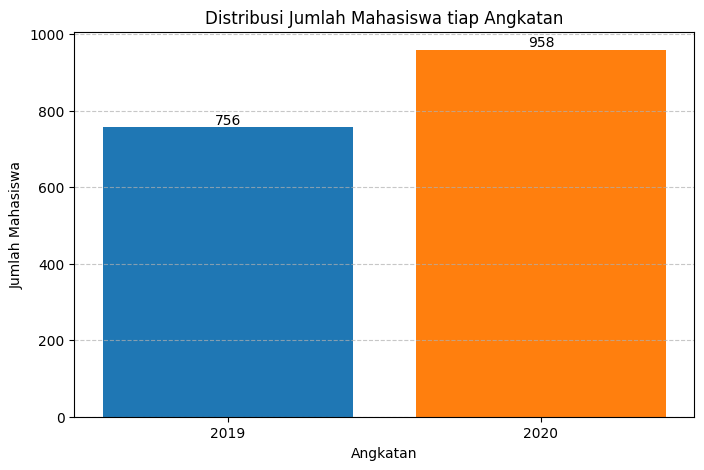


--- INSPEKSI 2: ANALISIS MAHASISWA TRANSFER ---
Angkatan 2019:
  - Teridentifikasi Transfer : 57 orang
  - Persentase Transfer      : 7.54% dari total angkatan 2019
Angkatan 2020:
  - Teridentifikasi Transfer : 76 orang
  - Persentase Transfer      : 7.93% dari total angkatan 2020
--------------------
TOTAL Mahasiswa Dibuang (Transfer) : 133
TOTAL Mahasiswa Tersisa (Normal)   : 1581


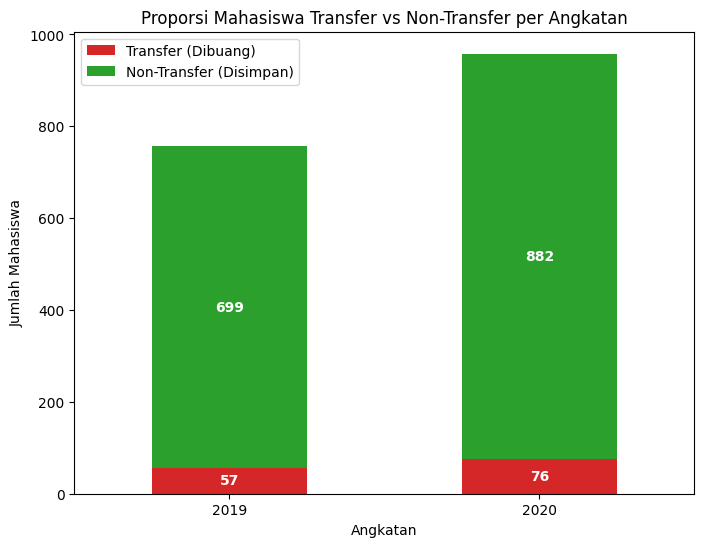

Data Siap. Jumlah baris: 1329
STATUS
Tepat Waktu    864
Terlambat      465
Name: count, dtype: int64


In [ ]:

# =============================================================================
# BAGIAN 1: DATA PREPARATION (LOGIKA KODE 1A)
# =============================================================================

folder_path = 'data_akademik/'
# Pastikan folder ada dan berisi file csv
if not os.path.exists(folder_path):
    print(f"Folder '{folder_path}' tidak ditemukan. Harap sesuaikan path.")
    files = []
else:
    files = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])

columns_to_keep = ['ANGKATAN', 'NIM', 'NAMA', 'SMT', 'IP_LULUS', 'SKS_LULUS', 'SKSK_LULUS']

# --- 1. LOAD & MERGE DATA ---
semester_data = []
for file in files:
    df = pd.read_csv(os.path.join(folder_path, file))
    cols = [c for c in columns_to_keep if c in df.columns]
    df = df[cols]
    semester_data.append(df)

if not semester_data:
    raise ValueError("Tidak ada data CSV yang diload. Cek folder path.")

df_all = pd.concat(semester_data, ignore_index=True)

# Filter Angkatan 2019-2020 & Semester 1-11
df_all = df_all[df_all['ANGKATAN'].isin([2019, 2020])]
df_all = df_all[df_all['SMT'].between(1, 11)]

# >>>>>> INSERT INSPEKSI 1 <<<<<<
inspect_angkatan_distribution(df_all)
# >>>>>>>>>>>>>>><<<<<<<<<<<<<<<<

# --- 2. FILTER MAHASISWA TRANSFER (VERSI BARU) ---
# Logic: Transfer jika SMT 1 ATAU 2 memiliki SKSK > 50
transfer_nims = df_all.loc[
    df_all['SMT'].isin([1, 2]) & (df_all['SKSK_LULUS'] > 50),
    'NIM'
].unique()

# >>>>>> INSERT INSPEKSI 2 <<<<<<
inspect_transfer_stats(df_all, transfer_nims)
# >>>>>>>>>>>>>>><<<<<<<<<<<<<<<<

df_all = df_all[~df_all['NIM'].isin(transfer_nims)]

# --- 3. PIVOT DATA (Fitur 1-6) ---
static_data = df_all.groupby('NIM')[['NAMA', 'ANGKATAN']].first()
df_features = df_all[df_all['SMT'].between(1, 6)].copy()

pivot_df = df_features.pivot_table(
    index='NIM',
    columns='SMT',
    values=['IP_LULUS', 'SKS_LULUS'],
    fill_value=0
)
pivot_df.columns = [f'{col}_SMT{smt}' for col, smt in pivot_df.columns]
integrasi_df = static_data.join(pivot_df, how='left').fillna(0)

# Info Semester & SKSK Terakhir
last_rec = df_all.sort_values('SMT').groupby('NIM').last()
integrasi_df['SMT_TERAKHIR'] = last_rec['SMT']
integrasi_df['SKSK_TERAKHIR'] = last_rec['SKSK_LULUS']

# --- 4. LOGIKA STATUS (LABELING) ---
piv_sksk = df_all.pivot_table(index='NIM', columns='SMT', values='SKSK_LULUS')

def determine_status(row):
    nim = row.name
    max_smt = row['SMT_TERAKHIR']

    if max_smt <= 6:
        return "Terlambat" if max_smt == 6 else "Undefined or DO"

    sksk7 = piv_sksk.loc[nim].get(7, np.nan)
    sksk8 = piv_sksk.loc[nim].get(8, np.nan)
    has_smt9_plus = max_smt >= 9

    if not np.isnan(sksk7) and sksk7 >= 144:
        if max_smt == 7: return "Tepat Waktu"

    if not np.isnan(sksk8) and sksk8 >= 144:
        if not has_smt9_plus: return "Tepat Waktu"

    return "Terlambat"

integrasi_df['STATUS'] = integrasi_df.apply(determine_status, axis=1)
integrasi_df = integrasi_df[integrasi_df['STATUS'] != "Undefined or DO"].copy()
integrasi_df = integrasi_df.reset_index()

print(f"Data Siap. Jumlah baris: {len(integrasi_df)}")
print(integrasi_df['STATUS'].value_counts())


#Persiapan Data 2

In [12]:
def viz_1_populasi_awal(df_all):
    """
    Menampilkan distribusi populasi awal dengan statistik persentase.
    """
    # Hitung jumlah unique NIM per Angkatan
    populasi = df_all.groupby('ANGKATAN')['NIM'].nunique().reset_index()
    populasi.columns = ['Angkatan', 'Jumlah']

    total_populasi = populasi['Jumlah'].sum()
    populasi['Persentase'] = (populasi['Jumlah'] / total_populasi * 100).round(1)

    print("\n" + "="*40)
    print(" [1] STATISTIK POPULASI AWAL")
    print("="*40)
    print(f"Total Keseluruhan Data: {total_populasi} Mahasiswa")
    print("-" * 40)
    print(populasi.to_string(index=False))
    print("-" * 40)

    plt.figure(figsize=(8, 5))
    ax = sns.barplot(data=populasi, x='Angkatan', y='Jumlah', palette='viridis')
    plt.title(f'Distribusi Populasi Awal (Total: {total_populasi})', fontsize=14)
    plt.xlabel('Angkatan')
    plt.ylabel('Jumlah Mahasiswa')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Menambah label angka pada batang
    for i in ax.containers:
        ax.bar_label(i, fmt='%d', padding=3)
    plt.show()

In [13]:
def viz_2_missing_values(df_features, static_data):
    """
    Stacked bar chart untuk Missing Values dengan angka di dalam batang
    dan statistik global lengkap/imputasi.
    """
    # Logika: Jika jumlah semester < 6, berarti ada missing values (imputasi)
    cek_kelengkapan = df_features.groupby('NIM')['SMT'].nunique()
    df_cek = static_data.join(cek_kelengkapan, how='left')
    df_cek['Status'] = df_cek['SMT'].apply(lambda x: 'Lengkap' if x == 6 else 'Terimputasi')

    # Buat Summary Table
    summary = df_cek.groupby(['ANGKATAN', 'Status']).size().unstack(fill_value=0)
    summary['Total'] = summary.sum(axis=1)

    # Hitung Statistik Global
    total_global = summary['Total'].sum()
    total_lengkap = summary['Lengkap'].sum()
    total_imputasi = summary['Terimputasi'].sum()
    pct_lengkap = (total_lengkap / total_global * 100).round(1)
    pct_imputasi = (total_imputasi / total_global * 100).round(1)

    print("\n" + "="*50)
    print(" [2] STATISTIK KELENGKAPAN DATA (IMPUTASI)")
    print("="*50)
    print(summary)
    print("-" * 50)
    print(f"TOTAL GLOBAL POPULASI: {total_global}")
    print(f" > Data Lengkap     : {total_lengkap} ({pct_lengkap}%)")
    print(f" > Data Terimputasi : {total_imputasi} ({pct_imputasi}%)")
    print("-" * 50)

    # Plotting Stacked Bar
    ax = summary[['Lengkap', 'Terimputasi']].plot(
        kind='bar', stacked=True, color=['#27ae60', '#e74c3c'], figsize=(9, 6)
    )
    plt.title('Status Kelengkapan Data Semester 1-6', fontsize=14)
    plt.ylabel('Jumlah Mahasiswa')
    plt.xticks(rotation=0)
    plt.legend(title='Status Data')
    plt.grid(axis='y', linestyle='--', alpha=0.7)


    # Menambahkan angka di tengah batang (label_type='center')
    for c in ax.containers:
        # Hanya tampilkan label jika nilainya > 0 agar tidak menumpuk
        labels = [int(v) if v > 0 else '' for v in c.datavalues]
        ax.bar_label(c, labels=labels, label_type='center', color='white', weight='bold')

    # Menambahkan total di atas batang
    # Kita hitung total per bar (Angkatan) untuk label di paling atas
    totals = summary[['Lengkap', 'Terimputasi']].sum(axis=1)
    # Karena ini stacked, posisi y total sedikit manual atau gunakan container terakhir + offset
    # Cara termudah: biarkan user melihat total dari sumbu Y, atau print tabel seperti di atas.

    plt.show()

In [14]:
def viz_3_transfer_filter(integrasi_df, is_transfer):
    """
    Statistik Mahasiswa Transfer vs Reguler dengan rincian total dan persentase.
    """
    df_viz = integrasi_df[['ANGKATAN']].copy()
    df_viz['Jenis'] = ['Transfer' if x else 'Reguler' for x in is_transfer]

    summary = df_viz.groupby(['ANGKATAN', 'Jenis']).size().unstack(fill_value=0)

    # Statistik Global
    total_reguler = summary['Reguler'].sum()
    total_transfer = summary.get('Transfer', 0).sum() if 'Transfer' in summary else 0
    total_all = total_reguler + total_transfer

    pct_reguler = (total_reguler / total_all * 100).round(1)
    pct_transfer = (total_transfer / total_all * 100).round(1)

    print("\n" + "="*50)
    print(" [3] STATISTIK FILTER TRANSFER")
    print("="*50)
    print(summary)
    print("-" * 50)
    print(f"TOTAL GLOBAL: {total_all}")
    print(f" > Reguler  : {total_reguler} ({pct_reguler}%)")
    print(f" > Transfer : {total_transfer} ({pct_transfer}%)")
    print("-" * 50)

    ax = summary.plot(kind='bar', figsize=(9, 6), color=['#27ae60', '#e74c3c'])
    plt.title(f'Perbandingan Mahasiswa Reguler vs Transfer (Total Transfer: {total_transfer})', fontsize=14)
    plt.ylabel('Jumlah Mahasiswa')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    for container in ax.containers:
        ax.bar_label(container, fmt='%d')
    plt.show()

In [15]:
def viz_4_do_undefined(df_labeled):
    """
    Statistik Drop Out / Undefined vs Valid Data.
    """
    do_data = df_labeled[df_labeled['STATUS'] == "Undefined or DO"]
    valid_data = df_labeled[df_labeled['STATUS'] != "Undefined or DO"]

    summary = pd.DataFrame({
        'Valid': valid_data.groupby('ANGKATAN').size(),
        'DO/Drop': do_data.groupby('ANGKATAN').size()
    }).fillna(0)

    # Statistik Global
    total_valid = summary['Valid'].sum()
    total_do = summary['DO/Drop'].sum()
    total_all = total_valid + total_do

    pct_valid = (total_valid / total_all * 100).round(1)
    pct_do = (total_do / total_all * 100).round(1)

    print("\n" + "="*50)
    print(" [4] STATISTIK SELEKSI DATA (DO/UNDEFINED)")
    print("="*50)
    print(summary)
    print("-" * 50)
    print(f"TOTAL GLOBAL (Setelah Filter Transfer): {total_all}")
    print(f" > Data Valid (Lanjut) : {total_valid} ({pct_valid}%)")
    print(f" > Data DO/Drop        : {total_do} ({pct_do}%)")
    print("-" * 50)

    ax = summary.plot(kind='bar', color=['#27ae60', '#e74c3c'], figsize=(9, 6))
    plt.title('Seleksi Data: Valid vs DO/Undefined', fontsize=14)
    plt.ylabel('Jumlah Mahasiswa')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    for container in ax.containers:
        ax.bar_label(container, fmt='%d')
    plt.show()

In [16]:
def viz_5_final_distribution(final_df):
    """
    Statistik Final: Tepat Waktu vs Terlambat.
    """
    summary = final_df.groupby(['ANGKATAN', 'STATUS']).size().unstack(fill_value=0)

    # Statistik Global
    total_tepat = summary['Tepat Waktu'].sum()
    total_telat = summary['Terlambat'].sum()
    total_final = total_tepat + total_telat

    pct_tepat = (total_tepat / total_final * 100).round(1)
    pct_telat = (total_telat / total_final * 100).round(1)

    print("\n" + "="*50)
    print(" [5] STATISTIK DATASET AKHIR (SIAP MINING)")
    print("="*50)
    print(summary)
    print("-" * 50)
    print(f"TOTAL DATASET FINAL: {total_final}")
    print(f" > Tepat Waktu : {total_tepat} ({pct_tepat}%)")
    print(f" > Terlambat   : {total_telat} ({pct_telat}%)")
    print("-" * 50)

    ax = summary.plot(kind='bar', color=['#1f77b4', '#ff7f0e'], figsize=(9, 6))
    plt.title(f'Distribusi Label Akhir (Total: {total_final})', fontsize=14)
    plt.ylabel('Jumlah Mahasiswa')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    for container in ax.containers:
        ax.bar_label(container, fmt='%d')
    plt.show()


 [1] STATISTIK POPULASI AWAL
Total Keseluruhan Data: 1714 Mahasiswa
----------------------------------------
 Angkatan  Jumlah  Persentase
     2019     756        44.1
     2020     958        55.9
----------------------------------------


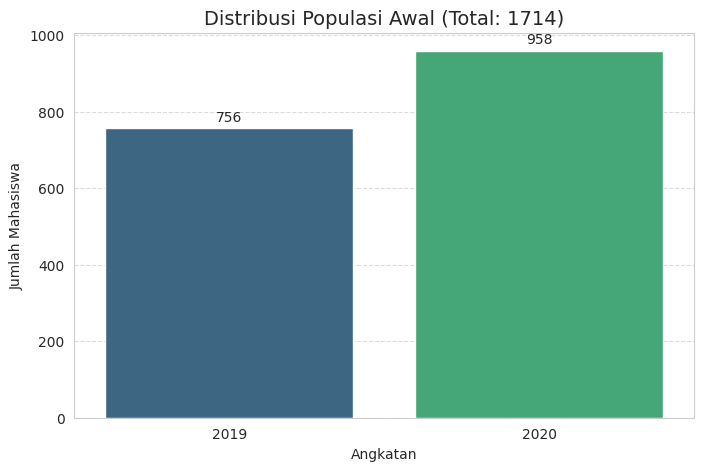


 [2] STATISTIK KELENGKAPAN DATA (IMPUTASI)
Status    Lengkap  Terimputasi  Total
ANGKATAN                             
2019          623          133    756
2020          700          258    958
--------------------------------------------------
TOTAL GLOBAL POPULASI: 1714
 > Data Lengkap     : 1323 (77.2%)
 > Data Terimputasi : 391 (22.8%)
--------------------------------------------------


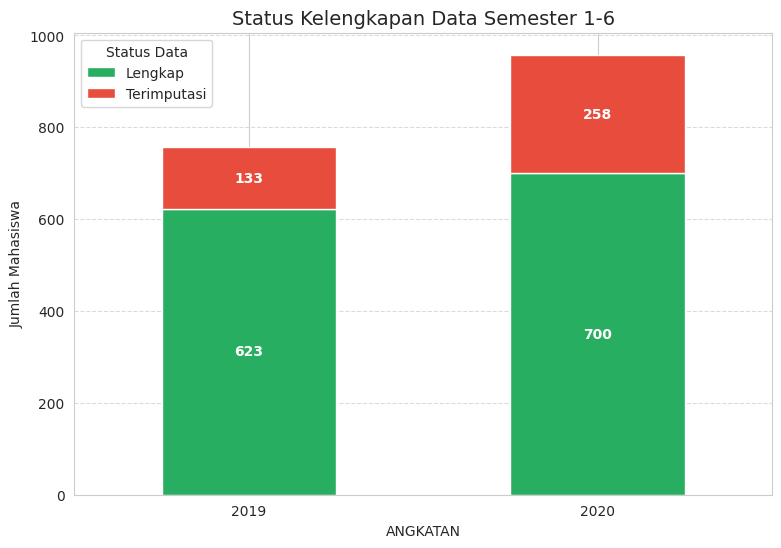


 [3] STATISTIK FILTER TRANSFER
Jenis     Reguler  Transfer
ANGKATAN                   
2019          699        57
2020          882        76
--------------------------------------------------
TOTAL GLOBAL: 1714
 > Reguler  : 1581 (92.2%)
 > Transfer : 133 (7.8%)
--------------------------------------------------


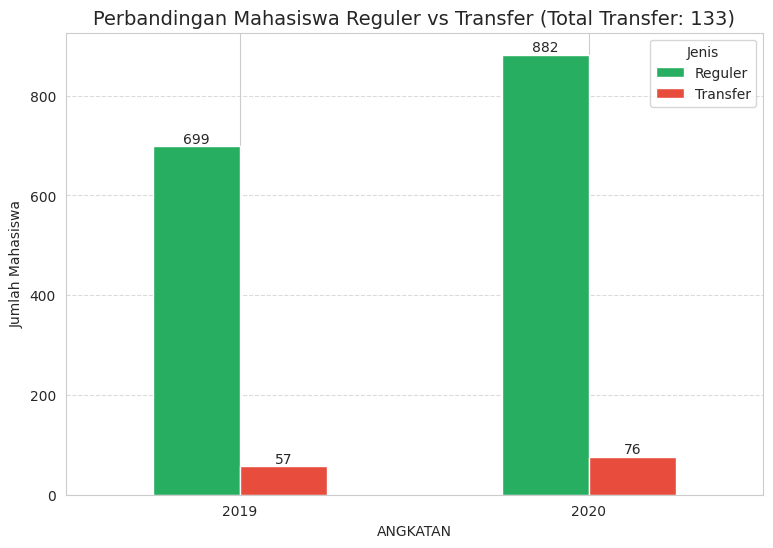


 [4] STATISTIK SELEKSI DATA (DO/UNDEFINED)
          Valid  DO/Drop
ANGKATAN                
2019        628       71
2020        701      181
--------------------------------------------------
TOTAL GLOBAL (Setelah Filter Transfer): 1581
 > Data Valid (Lanjut) : 1329 (84.1%)
 > Data DO/Drop        : 252 (15.9%)
--------------------------------------------------


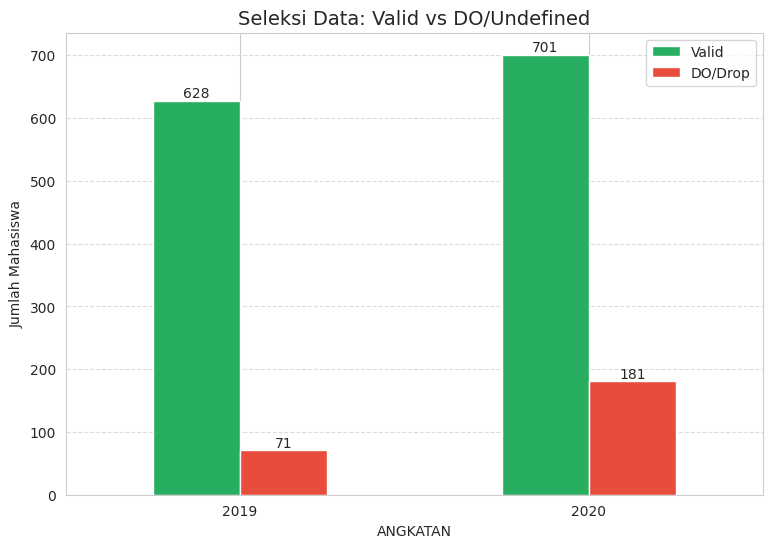

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1329 entries, 0 to 1328
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   NIM             1329 non-null   int64  
 1   NAMA            1329 non-null   object 
 2   ANGKATAN        1329 non-null   int64  
 3   IP_LULUS_SMT1   1329 non-null   float64
 4   IP_LULUS_SMT2   1329 non-null   float64
 5   IP_LULUS_SMT3   1329 non-null   float64
 6   IP_LULUS_SMT4   1329 non-null   float64
 7   IP_LULUS_SMT5   1329 non-null   float64
 8   IP_LULUS_SMT6   1329 non-null   float64
 9   SKS_LULUS_SMT1  1329 non-null   int64  
 10  SKS_LULUS_SMT2  1329 non-null   int64  
 11  SKS_LULUS_SMT3  1329 non-null   int64  
 12  SKS_LULUS_SMT4  1329 non-null   int64  
 13  SKS_LULUS_SMT5  1329 non-null   int64  
 14  SKS_LULUS_SMT6  1329 non-null   int64  
 15  SMT_TERAKHIR    1329 non-null   int64  
 16  SKSK_TERAKHIR   1329 non-null   int64  
 17  STATUS          1329 non-null   o

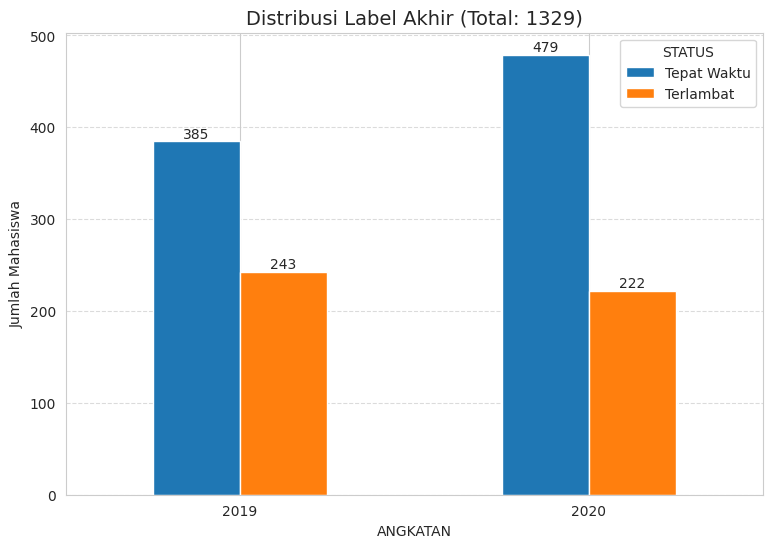

Data Siap (Kode 1B). Jumlah baris: 1329
STATUS
Tepat Waktu    864
Terlambat      465
Name: count, dtype: int64


In [17]:
import pandas as pd
import numpy as np
import os

# =============================================================================
# KODE 1B: LOGIKA TERBALIK (Imputasi Dulu -> Baru Filter Transfer)
# =============================================================================

folder_path = 'data_akademik/'
if not os.path.exists(folder_path):
    print(f"Folder '{folder_path}' tidak ditemukan.")
    files = []
else:
    files = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])

columns_to_keep = ['ANGKATAN', 'NIM', 'NAMA', 'SMT', 'IP_LULUS', 'SKS_LULUS', 'SKSK_LULUS']

# --- 1. LOAD & MERGE DATA ---
semester_data = []
for file in files:
    df = pd.read_csv(os.path.join(folder_path, file))
    cols = [c for c in columns_to_keep if c in df.columns]
    df = df[cols]
    semester_data.append(df)

if not semester_data:
    raise ValueError("Tidak ada data CSV.")

df_all = pd.concat(semester_data, ignore_index=True)

# Filter Angkatan 2019-2020 & Semester 1-11
df_all = df_all[df_all['ANGKATAN'].isin([2019, 2020])]
df_all = df_all[df_all['SMT'].between(1, 11)]

# df_all.info()

# ==========================================
# [VISUALISASI 1] Populasi Awal
# ==========================================
viz_1_populasi_awal(df_all)

# --- 2. PIVOT & IMPUTASI (DILAKUKAN LEBIH AWAL) ---
# Kita langsung membentuk data tabular untuk SMT 1-6.
# Imputasi terjadi otomatis di sini melalui 'fill_value=0'.
# NOTE: Kita sertakan 'SKSK_LULUS' di pivot agar bisa dicek untuk filter transfer nanti.

static_data = df_all.groupby('NIM')[['NAMA', 'ANGKATAN']].first()
df_features = df_all[df_all['SMT'].between(1, 6)].copy()

# ==========================================
# [VISUALISASI 2] Cek Missing Values Sebelum Pivot
# ==========================================
viz_2_missing_values(df_features, static_data)

pivot_df = df_features.pivot_table(
    index='NIM',
    columns='SMT',
    values=['IP_LULUS', 'SKS_LULUS', 'SKSK_LULUS'],
    fill_value=0  # <--- INI PROSES IMPUTASINYA (Missing Value jadi 0)
)

# Flatten MultiIndex Columns (Contoh: SKS_LULUS_SMT1, SKSK_LULUS_SMT1)
pivot_df.columns = [f'{col}_SMT{smt}' for col, smt in pivot_df.columns]
integrasi_df = static_data.join(pivot_df, how='left').fillna(0)

# # Hapus kolom bantuan SKSK jika tidak ingin dipakai di training model
# drop_cols = [c for c in integrasi_df.columns if 'SKSK_LULUS' in c]
# integrasi_df = integrasi_df.drop(columns=drop_cols)


# --- 3. FILTER MAHASISWA TRANSFER (SETELAH IMPUTASI) ---
# Logic: Transfer jika SKSK_LULUS di SMT 1 atau SMT 2 > 50.
# Karena data sudah di-pivot, kita cek kolomnya langsung.

# Pastikan kolom tersedia (jaga-jaga jika data kosong total)
col_sksk1 = 'SKSK_LULUS_SMT1'
col_sksk2 = 'SKSK_LULUS_SMT2'

is_transfer = pd.Series(False, index=integrasi_df.index)

# Cek Semester 1
if col_sksk1 in integrasi_df.columns:
    is_transfer = is_transfer | (integrasi_df[col_sksk1] > 50)

# Cek Semester 2
if col_sksk2 in integrasi_df.columns:
    is_transfer = is_transfer | (integrasi_df[col_sksk2] > 50)


# ==========================================
# [VISUALISASI 3] Cek Filter Transfer
# ==========================================
viz_3_transfer_filter(integrasi_df, is_transfer)


# Simpan mahasiswa Non-Transfer saja
integrasi_df = integrasi_df[~is_transfer].copy()

# Ambil daftar NIM bersih untuk referensi Labeling
valid_nims = integrasi_df.index

# =============================================================================
# BAGIAN LABELING
# =============================================================================

# Kita filter df_all agar labeling hanya menghitung mahasiswa yang valid (Non-Transfer)
df_clean_log = df_all[df_all['NIM'].isin(valid_nims)]


# Info Semester & SKSK Terakhir (Untuk Labeling)
last_rec = df_clean_log.sort_values('SMT').groupby('NIM').last()
integrasi_df['SMT_TERAKHIR'] = last_rec['SMT']
integrasi_df['SKSK_TERAKHIR'] = last_rec['SKSK_LULUS']

# Pivot SKSK untuk Logic Labeling (Cek SKSK di Smt 7 & 8)
piv_sksk_label = df_clean_log.pivot_table(index='NIM', columns='SMT', values='SKSK_LULUS')

def determine_status(row):
    nim = row.name
    # Handle jika data last record tidak ditemukan (seharusnya ada)
    if pd.isna(row['SMT_TERAKHIR']): return "Undefined or DO"

    max_smt = row['SMT_TERAKHIR']

    if max_smt <= 6:
        return "Terlambat" if max_smt == 6 else "Undefined or DO"

    sksk7 = piv_sksk_label.loc[nim].get(7, np.nan)
    sksk8 = piv_sksk_label.loc[nim].get(8, np.nan)
    has_smt9_plus = max_smt >= 9

    if not np.isnan(sksk7) and sksk7 >= 144:
        if max_smt == 7: return "Tepat Waktu"

    if not np.isnan(sksk8) and sksk8 >= 144:
        if not has_smt9_plus: return "Tepat Waktu"

    return "Terlambat"

integrasi_df['STATUS'] = integrasi_df.apply(determine_status, axis=1)

# ==========================================
# [VISUALISASI 4] Cek DO / Undefined sebelum dibuang
# ==========================================
viz_4_do_undefined(integrasi_df)


integrasi_df = integrasi_df[integrasi_df['STATUS'] != "Undefined or DO"].copy()
integrasi_df = integrasi_df.reset_index()

# Hapus kolom bantuan SKSK jika tidak ingin dipakai di training model
drop_cols = [c for c in integrasi_df.columns if 'SKSK_LULUS' in c]
integrasi_df = integrasi_df.drop(columns=drop_cols)

#--- [PERBAIKAN TIPE DATA] ---
# Cari semua kolom yang namanya mengandung "SKS" (baik SKS_LULUS maupun SKSK_LULUS)
cols_to_int = [col for col in integrasi_df.columns if 'SKS' in col]
# Paksa ubah tipe datanya menjadi integer
integrasi_df[cols_to_int] = integrasi_df[cols_to_int].astype(int)
integrasi_df.info()

viz_5_final_distribution(integrasi_df)
print(f"Data Siap (Kode 1B). Jumlah baris: {len(integrasi_df)}")
print(integrasi_df['STATUS'].value_counts())



In [18]:
# Import ke CSV validasi manual
integrasi_df = integrasi_df.drop(['NAMA', 'NIM', 'ANGKATAN', 'SMT_TERAKHIR', 'SKSK_TERAKHIR'], axis=1)

integrasi_df.to_csv('integrasi_final.csv', index=False)

#EDA

In [ ]:
# integrasi_df = pd.read_csv("integrasi_final.csv")
# # Tampilkan tabel integrasi
df_model.head()

,NIM,NAMA,ANGKATAN,IP_LULUS_SMT1,IP_LULUS_SMT2,IP_LULUS_SMT3,IP_LULUS_SMT4,IP_LULUS_SMT5,IP_LULUS_SMT6,SKS_LULUS_SMT1,SKS_LULUS_SMT2,SKS_LULUS_SMT3,SKS_LULUS_SMT4,SKS_LULUS_SMT5,SKS_LULUS_SMT6,SMT_TERAKHIR,SKSK_TERAKHIR,STATUS
0,195150200111001,Nata Nirwasita Rasendriya,2019,3.26,3.33,3.54,3.67,3.07,3.57,19,20,24,21,22,22,8,148,Tepat Waktu
1,195150200111002,Aristo Renaldo Ruslim,2019,3.89,4.00,3.82,3.88,3.94,3.75,19,20,22,21,24,20,8,145,Tepat Waktu
2,195150200111003,KAUTSARRATU ATHAYA ZAYYANNNARANTIS,2019,3.11,3.52,3.72,3.62,3.45,3.43,19,20,23,24,21,20,9,144,Terlambat
3,195150200111004,IKBAL WALUDI,2019,3.47,3.55,3.00,3.66,3.59,3.58,19,20,24,22,23,24,11,137,Terlambat
4,195150200111005,Zidane El Faruqi,2019,2.79,3.85,3.92,3.68,3.43,3.55,19,20,24,19,22,20,9,149,Terlambat


In [ ]:
# cek info
integrasi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1329 entries, 0 to 1328
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   NIM             1329 non-null   int64  
 1   NAMA            1329 non-null   object 
 2   ANGKATAN        1329 non-null   int64  
 3   IP_LULUS_SMT1   1329 non-null   float64
 4   IP_LULUS_SMT2   1329 non-null   float64
 5   IP_LULUS_SMT3   1329 non-null   float64
 6   IP_LULUS_SMT4   1329 non-null   float64
 7   IP_LULUS_SMT5   1329 non-null   float64
 8   IP_LULUS_SMT6   1329 non-null   float64
 9   SKS_LULUS_SMT1  1329 non-null   int64  
 10  SKS_LULUS_SMT2  1329 non-null   int64  
 11  SKS_LULUS_SMT3  1329 non-null   int64  
 12  SKS_LULUS_SMT4  1329 non-null   int64  
 13  SKS_LULUS_SMT5  1329 non-null   int64  
 14  SKS_LULUS_SMT6  1329 non-null   int64  
 15  SMT_TERAKHIR    1329 non-null   int64  
 16  SKSK_TERAKHIR   1329 non-null   int64  
 17  STATUS          1329 non-null   o

In [ ]:
# Cek bentuk data
print("Jumlah Baris & Kolom:", integrasi_df.shape)

Jumlah Baris & Kolom: (1329, 18)


In [ ]:
# Jumlah missing value per kolom
missing_values = integrasi_df.isnull().sum()
print("Missing Values:\n", missing_values[missing_values > 0])


Missing Values:
 Series([], dtype: int64)


In [ ]:
# Cek distribusi tabel
print(integrasi_df.describe())

                NIM     ANGKATAN  IP_LULUS_SMT1  IP_LULUS_SMT2  IP_LULUS_SMT3  \
count  1.329000e+03  1329.000000    1329.000000    1329.000000    1329.000000   
mean   2.004250e+14  2019.527464       3.500632       3.604673       3.558345   
std    4.994337e+12     0.499433       0.408188       0.397273       0.455644   
min    1.951502e+14  2019.000000       0.000000       0.000000       0.000000   
25%    1.951503e+14  2019.000000       3.290000       3.450000       3.410000   
50%    2.051502e+14  2020.000000       3.580000       3.690000       3.670000   
75%    2.051504e+14  2020.000000       3.820000       3.870000       3.830000   
max    2.051507e+14  2020.000000       4.000000       4.000000       4.000000   

       IP_LULUS_SMT4  IP_LULUS_SMT5  IP_LULUS_SMT6  SKS_LULUS_SMT1  \
count    1329.000000    1329.000000    1329.000000     1329.000000   
mean        3.555779       3.557976       3.513582       19.179082   
std         0.493985       0.535887       0.625246        1.

In [ ]:
# Cek distribusi Kelas target
print("Distribusi Target:\n", integrasi_df['STATUS'].value_counts())

Distribusi Target:
 STATUS
Tepat Waktu    864
Terlambat      465
Name: count, dtype: int64


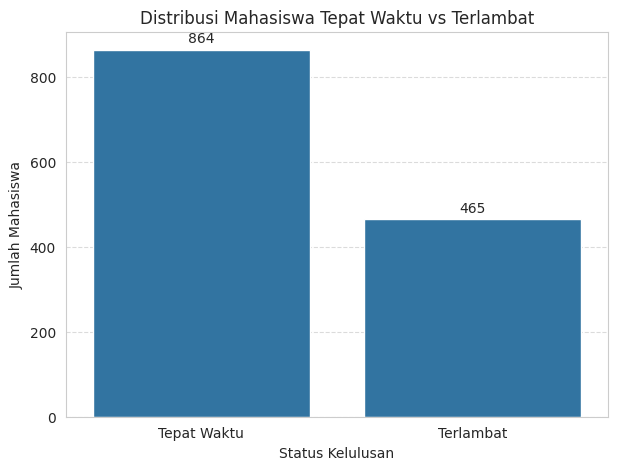

In [ ]:
# Visualisasi proprsi terlambat
# Visualisasi proprsi terlambat
plt.figure(figsize=(7, 5))
ax = sns.countplot(x='STATUS', data=integrasi_df)
plt.title('Distribusi Mahasiswa Tepat Waktu vs Terlambat')
plt.xlabel('Status Kelulusan')
plt.ylabel('Jumlah Mahasiswa')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i in ax.containers:
        ax.bar_label(i, fmt='%d', padding=3)
plt.show()



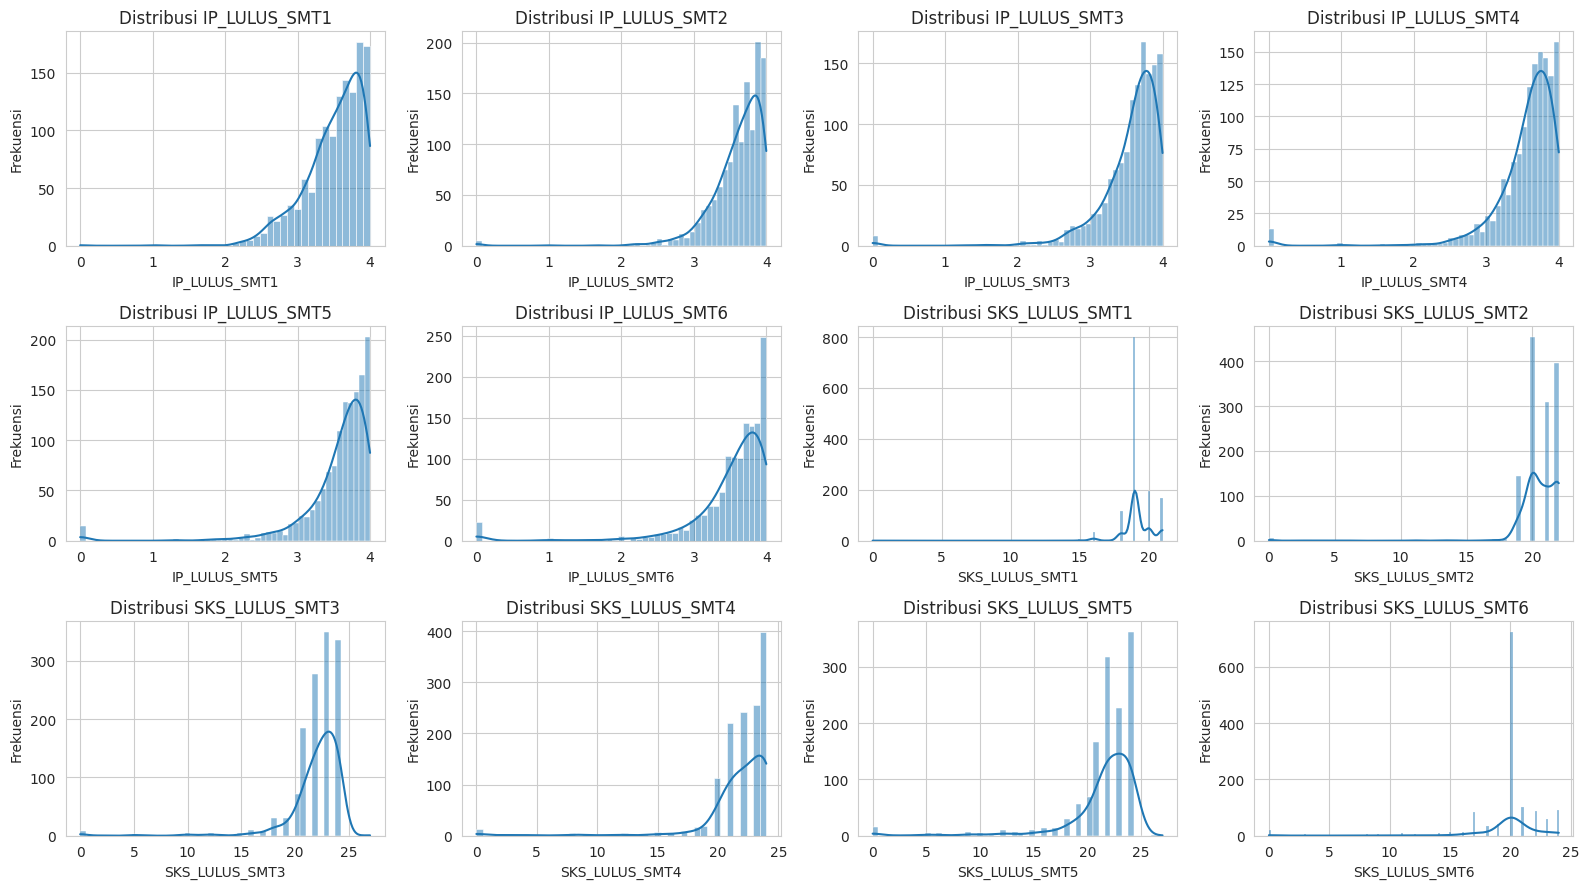

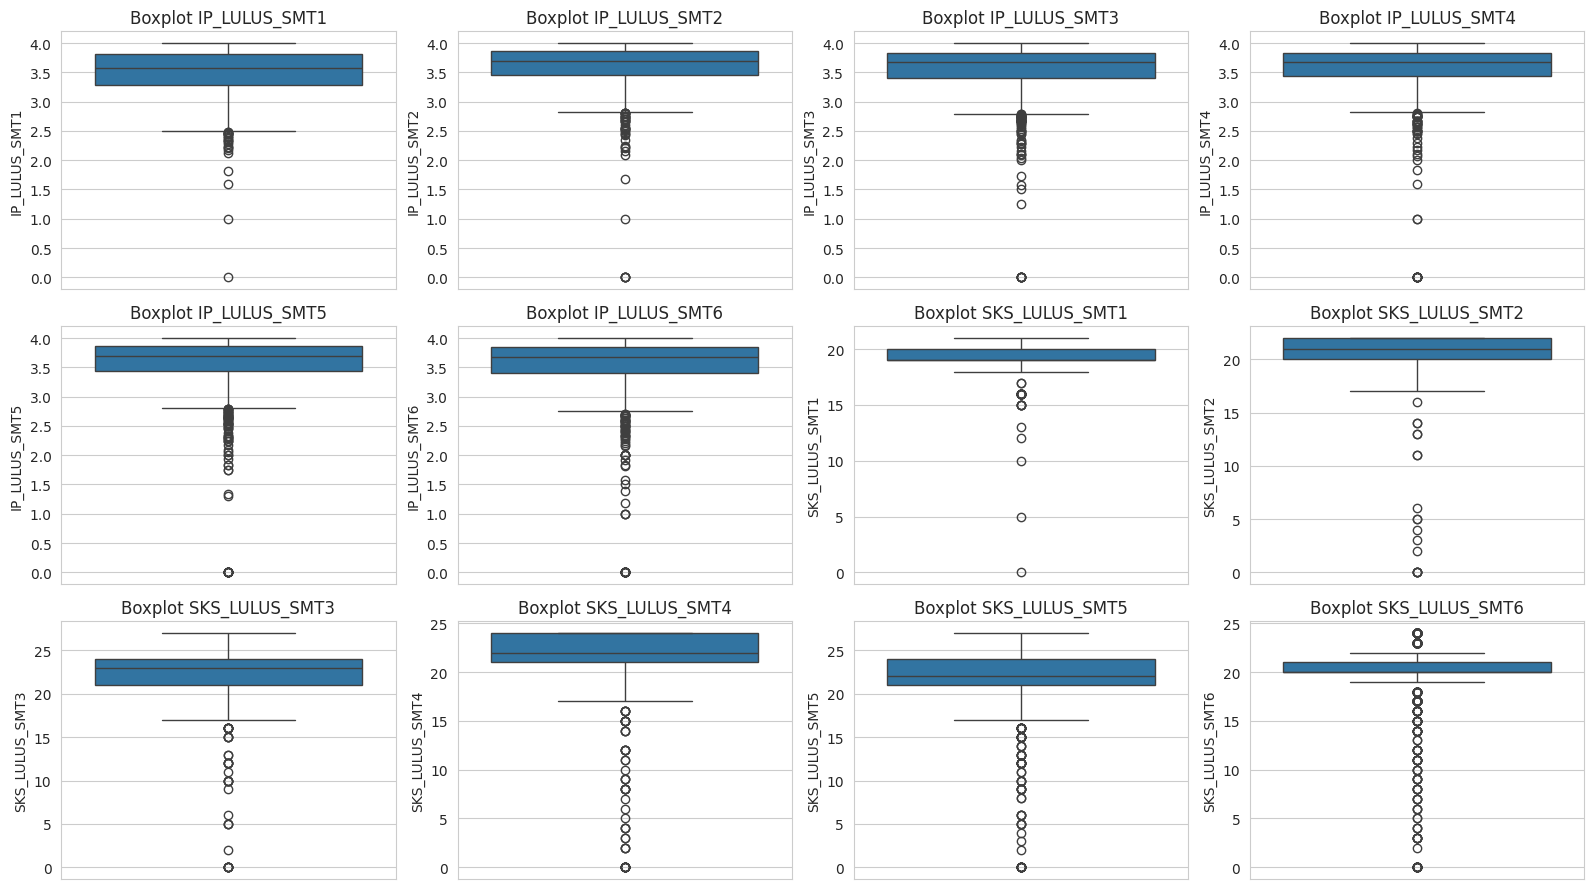

In [ ]:
# Pilih kolom yang akan divisualisasikan (semua kecuali NAMA, NIM, ANGKATAN, dan TARGET)
# Target column is excluded for now as it's a categorical feature already visualized
columns_to_visualize = integrasi_df.drop(['NAMA', 'NIM', 'ANGKATAN', 'STATUS', 'SMT_TERAKHIR','SKSK_TERAKHIR'], axis=1).columns

# Tentukan jumlah baris dan kolom untuk subplot
n_cols = 4
n_rows = (len(columns_to_visualize) + n_cols - 1) // n_cols

# Buat histogram untuk setiap kolom
plt.figure(figsize=(n_cols * 4, n_rows * 3))
for i, col in enumerate(columns_to_visualize):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(integrasi_df[col], kde=True)
    plt.title(f'Distribusi {col}')
    plt.xlabel(col)
    plt.ylabel('Frekuensi')
plt.tight_layout()
plt.show()

# Buat boxplot untuk setiap kolom
plt.figure(figsize=(n_cols * 4, n_rows * 3))
for i, col in enumerate(columns_to_visualize):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(y=integrasi_df[col])
    plt.title(f'Boxplot {col}')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

# Training terakhir

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1329 entries, 0 to 1328
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   IP_LULUS_SMT1   1329 non-null   float64
 1   IP_LULUS_SMT2   1329 non-null   float64
 2   IP_LULUS_SMT3   1329 non-null   float64
 3   IP_LULUS_SMT4   1329 non-null   float64
 4   IP_LULUS_SMT5   1329 non-null   float64
 5   IP_LULUS_SMT6   1329 non-null   float64
 6   SKS_LULUS_SMT1  1329 non-null   int64  
 7   SKS_LULUS_SMT2  1329 non-null   int64  
 8   SKS_LULUS_SMT3  1329 non-null   int64  
 9   SKS_LULUS_SMT4  1329 non-null   int64  
 10  SKS_LULUS_SMT5  1329 non-null   int64  
 11  SKS_LULUS_SMT6  1329 non-null   int64  
 12  STATUS          1329 non-null   object 
dtypes: float64(6), int64(6), object(1)
memory usage: 135.1+ KB
       IP_LULUS_SMT1  IP_LULUS_SMT2  IP_LULUS_SMT3  IP_LULUS_SMT4  \
count    1329.000000    1329.000000    1329.000000    1329.000000   
mean        3.50

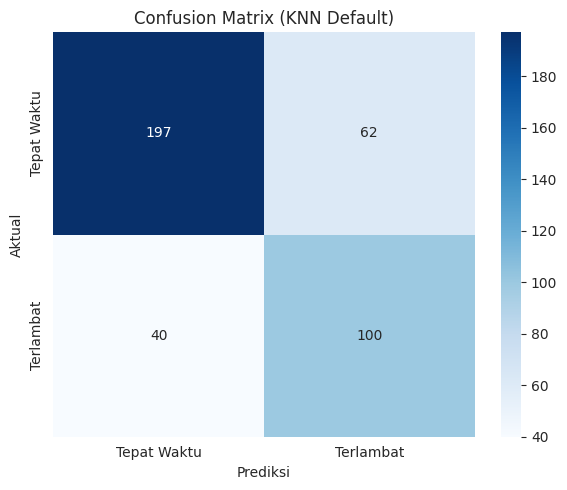


=== ROC AUC SCORE ===
ROC AUC Score: 0.7720
Grafik ROC Curve berhasil disimpan sebagai 'roc_curve_1ax.png'


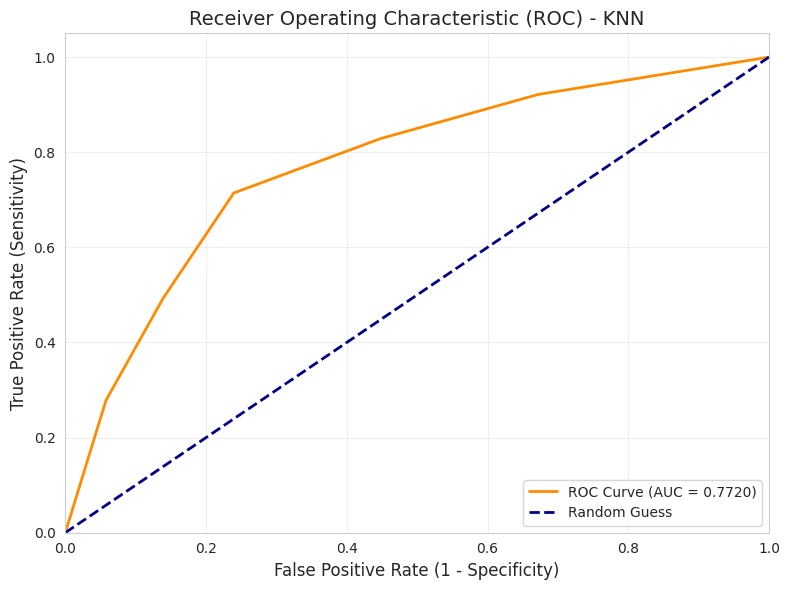

In [20]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Library Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Library Imbalanced Data
from imblearn.over_sampling import SVMSMOTE

# =============================================================================
# BAGIAN 2: MACHINE LEARNING (KODE 1AX)
# =============================================================================

# 1. PREPROCESSING
# ----------------
# Drop metadata
# df_model = integrasi_df.drop(['NAMA', 'NIM', 'ANGKATAN', 'SMT_TERAKHIR', 'SKSK_TERAKHIR'], axis=1)

df_model = pd.read_csv("integrasi_final.csv")
df_model.head()
df_model.info()
print(df_model.describe())

X = df_model.drop('STATUS', axis=1)
y = df_model['STATUS']

# Encoding Target (Tepat Waktu=0, Terlambat=1)
le = LabelEncoder()
y = le.fit_transform(y)

print("Hasil Encoding")
# Menampilkan Mapping Kelas
for i, class_name in enumerate(le.classes_):
    print(f"Target Asli: '{class_name}'  -->  Diubah jadi Angka: {i}")
# Menampilkan Distribusi Target Total (y)
unique, counts = np.unique(y, return_counts=True)
dist_y = dict(zip(unique, counts))
print(f"Distribusi Target : {dist_y}")


# Split Data (70:30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
print("\n CEK SPLIT DATA")
print(f"Dimensi X_train (70%) : {X_train.shape}")
print(f"Dimensi X_test  (30%) : {X_test.shape}")

# Cek apakah Stratify berhasil (Persentase kelas 0 dan 1 harus mirip di Train & Test)
pct_train = pd.Series(y_train).value_counts(normalize=True).sort_index()
pct_test = pd.Series(y_test).value_counts(normalize=True).sort_index()

print("\n Proporsi Kelas di Training Set:")
print(pct_train.round(4).to_dict())
print("Proporsi Kelas di Testing Set:")
print(pct_test.round(4).to_dict())

if abs(pct_train[1] - pct_test[1]) < 0.05:
    print("Stratify Berhasil (Proporsi seimbang).")
else:
    print("Proporsi kelas antara Train dan Test berbeda jauh!")



# Scaler (Fit on Train, Transform on Test)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("SEBELUM SCALING (Data Asli X_train):")
print(X_train.iloc[:, 0].describe()[['min', 'max', 'mean']].to_string())

# Statistik Setelah Scaling (Harus 0 s.d 1)
print("\n SETELAH SCALING (Data X_train_scaled):")
col_0_scaled = X_train_scaled[:, 0] # Ambil kolom pertama dari array
print(f"   Min  : {col_0_scaled.min():.4f}")
print(f"   Max  : {col_0_scaled.max():.4f}")
print(f"   Mean : {col_0_scaled.mean():.4f}")

if col_0_scaled.min() == 0 and col_0_scaled.max() == 1:
    print(" [OK] Scaling Berhasil (Rentang 0 - 1).")
else:
    print(" [WARNING] Scaling sepertinya bermasalah.")

print("="*50 + "\n")



# Oversampling (SVMSMOTE) - HANYA PADA TRAIN
svm_smote = SVMSMOTE(random_state=42, k_neighbors=5)
X_train_resampled, y_train_resampled = svm_smote.fit_resample(X_train_scaled, y_train)

print(f"\nJumlah Training Awal: {len(y_train)}")
print(f"Jumlah Training setelah SMOTE: {len(y_train_resampled)}")


# 2. MODELING & CROSS VALIDATION (TANPA TUNING)
# ---------------------------------------------
# Inisialisasi KNN Standar (Default n_neighbors=5)
knn = KNeighborsClassifier(n_neighbors=5)

# A. Stratified K-Fold CV = 5
skf5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_5 = cross_val_score(knn, X_train_resampled, y_train_resampled, cv=skf5, scoring='f1_macro')

# B. Stratified K-Fold CV = 10
skf10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores_10 = cross_val_score(knn, X_train_resampled, y_train_resampled, cv=skf10, scoring='f1_macro')

print("\n=== HASIL CROSS VALIDATION (Pada Data Training Resampled) ===")
print(f"Average F1-Macro (CV=5) : {cv_scores_5.mean():.4f} (+/- {cv_scores_5.std():.4f})")
print(f"Average F1-Macro (CV=10): {cv_scores_10.mean():.4f} (+/- {cv_scores_10.std():.4f})")


# 3. EVALUASI FINAL (PADA DATA TEST)
# ----------------------------------
# Train model pada seluruh data training yang sudah di-resample
knn.fit(X_train_resampled, y_train_resampled)

# Prediksi ke data test (Data Clean / Asli)
y_pred = knn.predict(X_test_scaled)
y_proba = knn.predict_proba(X_test_scaled)[:, 1]

target_names = [str(c) for c in le.classes_]

print("\n=== CLASSIFICATION REPORT (TEST SET) ===")
print(classification_report(y_test, y_pred, target_names=target_names))

print("=== CONFUSION MATRIX ===")
print(confusion_matrix(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
# Simpan Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix (KNN Default)')
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.tight_layout()
plt.savefig('confusion_matrix_1ax.png')
plt.show()
plt.close()

print("\n=== ROC AUC SCORE ===")
roc_score = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_score:.4f}")

#VISUALISASI ROC CURVE
# =======================================================
from sklearn.metrics import roc_curve

# 1. Hitung False Positive Rate (FPR) dan True Positive Rate (TPR)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# 2. Plotting
plt.figure(figsize=(8, 6))

# Garis ROC Model
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_score:.4f})')

# Garis Baseline (Tebakan Acak / 50:50)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

# Dekorasi Grafik
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) - KNN', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# Simpan dan Tampilkan
plt.tight_layout()
plt.savefig('roc_curve_1ax.png')
print("Grafik ROC Curve berhasil disimpan sebagai 'roc_curve_1ax.png'")
plt.show()
plt.close()

In [21]:
import joblib
import os

# Pastikan folder ada
if not os.path.exists('model_deploy'):
    os.makedirs('model_deploy')

# GANTI 'knn_final' DENGAN NAMA VARIABEL MODEL TERAKHIRMU
# GANTI 'scaler_final' DENGAN VARIABEL SCALER TERAKHIRMU
# GANTI 'le' DENGAN VARIABEL LABEL ENCODERMU

# Contoh (sesuaikan dengan variabel di kodemu):
# joblib.dump(best_knn, 'model_deploy/model_knn.pkl') # Jika pakai tuning
# joblib.dump(scaler, 'model_deploy/scaler.pkl')
# joblib.dump(le, 'model_deploy/label_encoder.pkl')

# JIKA KAMU MENGGUNAKAN KODE TERAKHIR KITA (30% + MinMax + SVMSMOTE), kemungkinan variabelnya:
joblib.dump(knn, 'model_deploy/model_knn.pkl')
joblib.dump(scaler, 'model_deploy/scaler.pkl')
joblib.dump(le, 'model_deploy/label_encoder.pkl')

print("Model berhasil disimpan di folder 'model_deploy'!")

Model berhasil disimpan di folder 'model_deploy'!


#Analysis


=== PERBANDINGAN PERFORMA (Threshold Default 0.5 vs 0.7) ===


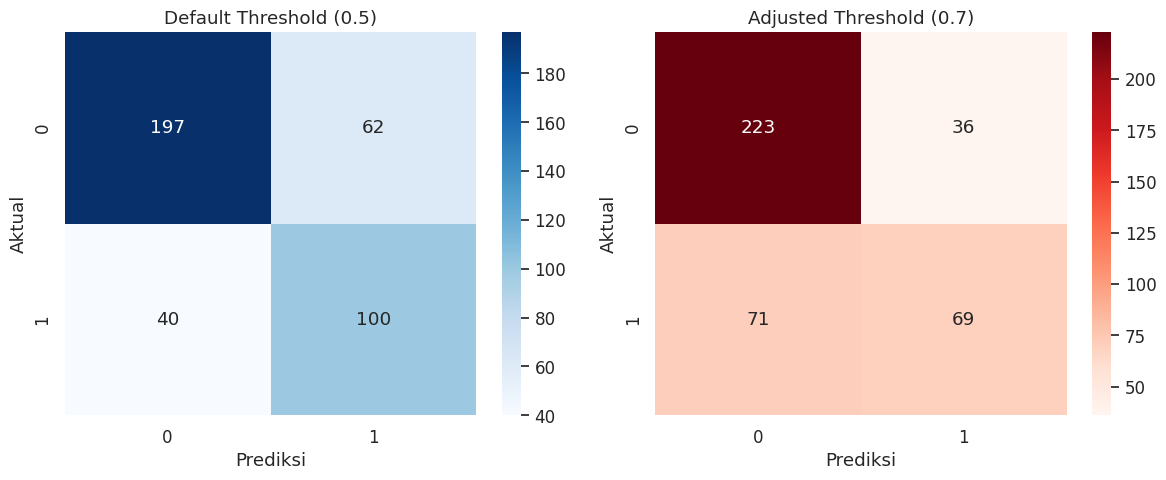


[INFO] Fokus pada Recall (Sensitivity) kelas 'Terlambat':
              precision    recall  f1-score   support

 Tepat Waktu       0.76      0.86      0.81       259
   Terlambat       0.66      0.49      0.56       140

    accuracy                           0.73       399
   macro avg       0.71      0.68      0.68       399
weighted avg       0.72      0.73      0.72       399



In [ ]:
# =========================================================
# ANALISIS A: THRESHOLD MOVING
# =========================================================
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Tentukan Threshold Baru (Lebih sensitif)
custom_threshold = 0.70  # Bisa kamu ubah (misal 0.3, 0.4)

# 2. Ambil probabilitas kelas positif (Terlambat)
y_proba_terlambat = knn.predict_proba(X_test_scaled)[:, 1]

# 3. Buat prediksi baru berdasarkan threshold
y_pred_adjusted = (y_proba_terlambat >= custom_threshold).astype(int)

# --- VISUALISASI PERBANDINGAN ---
print(f"\n=== PERBANDINGAN PERFORMA (Threshold Default 0.5 vs {custom_threshold}) ===")

# Hitung Confusion Matrix
cm_default = confusion_matrix(y_test, knn.predict(X_test_scaled))
cm_adjusted = confusion_matrix(y_test, y_pred_adjusted)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Default
sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Default Threshold (0.5)')
axes[0].set_xlabel('Prediksi')
axes[0].set_ylabel('Aktual')

# Plot Adjusted
sns.heatmap(cm_adjusted, annot=True, fmt='d', cmap='Reds', ax=axes[1])
axes[1].set_title(f'Adjusted Threshold ({custom_threshold})')
axes[1].set_xlabel('Prediksi')
axes[1].set_ylabel('Aktual')

plt.tight_layout()
plt.show()

# Print Report Khusus Recall Kelas 1
print("\n[INFO] Fokus pada Recall (Sensitivity) kelas 'Terlambat':")
print(classification_report(y_test, y_pred_adjusted, target_names=['Tepat Waktu', 'Terlambat']))

In [ ]:
# =========================================================
# ANALISIS B: MISCLASSIFICATION DRILL-DOWN
# =========================================================

# 1. Gabungkan Data Test Asli (X_test) dengan Prediksi
df_analysis = X_test.copy()
df_analysis['Aktual'] = y_test
df_analysis['Prediksi_Default'] = knn.predict(X_test_scaled)

# 2. Filter Kasus False Negative (Bahaya: Aslinya Terlambat, Diprediksi Tepat)
# Ingat: 1 = Terlambat, 0 = Tepat Waktu
false_negatives = df_analysis[(df_analysis['Aktual'] == 1) & (df_analysis['Prediksi_Default'] == 0)]

# 3. Filter Kasus True Positive (Sukses: Aslinya Terlambat, Terdeteksi Terlambat)
true_positives = df_analysis[(df_analysis['Aktual'] == 1) & (df_analysis['Prediksi_Default'] == 1)]

print(f"\nJumlah Meleset (False Negative): {len(false_negatives)}")
print(f"Jumlah Terdeteksi (True Positive): {len(true_positives)}")

# 4. Bandingkan Rata-rata Fitur Utama
cols_to_compare = ['IP_LULUS_SMT3', 'IP_LULUS_SMT4', 'IP_LULUS_SMT5', 'IP_LULUS_SMT6', 'SKS_LULUS_SMT3', 'SKS_LULUS_SMT4', 'SKS_LULUS_SMT5', 'SKS_LULUS_SMT6'] # Ganti sesuai fiturmu

comparison = pd.DataFrame({
    'Rata-rata (Gagal Terdeteksi)': false_negatives[cols_to_compare].mean(),
    'Rata-rata (Berhasil Terdeteksi)': true_positives[cols_to_compare].mean()
})

print("\n=== KENAPA MODEL SALAH TEBAK? ===")
print("Perbandingan Karakteristik Mahasiswa Terlambat:")
print(comparison)

# Opsional: Lihat sampel data yang salah
print("\n5 Sampel Data yang Gagal Terdeteksi:")
print(false_negatives.head(5))


Jumlah Meleset (False Negative): 40
Jumlah Terdeteksi (True Positive): 100

=== KENAPA MODEL SALAH TEBAK? ===
Perbandingan Karakteristik Mahasiswa Terlambat:
                Rata-rata (Gagal Terdeteksi)  Rata-rata (Berhasil Terdeteksi)
IP_LULUS_SMT3                        3.64150                           3.1186
IP_LULUS_SMT4                        3.59650                           3.1799
IP_LULUS_SMT5                        3.66425                           3.1170
IP_LULUS_SMT6                        3.63875                           3.0492
SKS_LULUS_SMT3                      22.07500                          19.8300
SKS_LULUS_SMT4                      22.10000                          19.2600
SKS_LULUS_SMT5                      22.17500                          18.0900
SKS_LULUS_SMT6                      20.25000                          17.1400

5 Sampel Data yang Gagal Terdeteksi:
      IP_LULUS_SMT1  IP_LULUS_SMT2  IP_LULUS_SMT3  IP_LULUS_SMT4  \
1010           3.93           3.8


Sedang Menganalisis Mahasiswa Index ke-7...
Data Awal IP Smt 4: 3.55


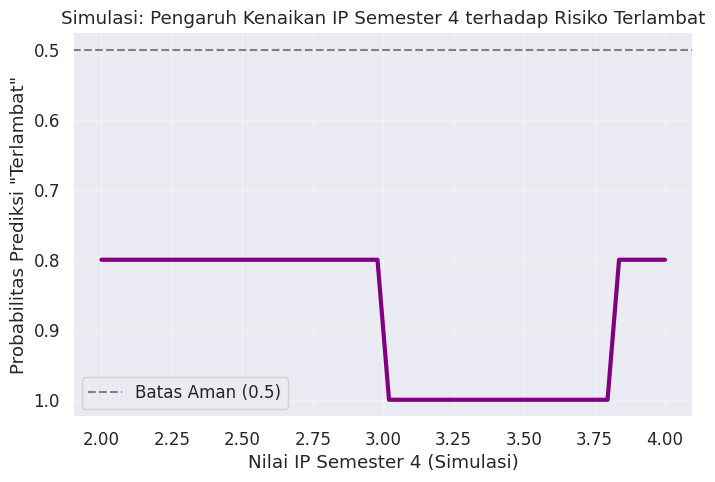

In [ ]:
# =========================================================
# ANALISIS C: SENSITIVITY ANALYSIS (WHAT-IF)
# =========================================================

# 1. Pilih 1 Mahasiswa secara acak yang diprediksi 'Terlambat' (Probabilitas tinggi)
# Kita cari index dari data test
target_indices = np.where(knn.predict_proba(X_test_scaled)[:, 1] > 0.8)[0]

if len(target_indices) > 0:
    sample_idx = target_indices[0] # Ambil orang pertama
    sample_data_raw = X_test.iloc[[sample_idx]].copy()

    print(f"\nSedang Menganalisis Mahasiswa Index ke-{sample_idx}...")
    print(f"Data Awal IP Smt 4: {sample_data_raw['IP_LULUS_SMT4'].values[0]}")

    # 2. Skenario: Apa yang terjadi jika IP Semester 4 dia naik?
    # Kita buat rentang nilai IP dari 2.0 sampai 4.0
    nilai_simulasi = np.linspace(2.0, 4.0, 50)
    probs_terlambat = []

    for nilai in nilai_simulasi:
        # Copy data, ubah nilainya
        temp_data = sample_data_raw.copy()
        temp_data['IP_LULUS_SMT4'] = nilai  # Ubah fitur yang ingin dites

        # PENTING: Lakukan Scaling ulang menggunakan scaler yang sudah dilatih
        temp_scaled = scaler.transform(temp_data)

        # Prediksi probabilitas 'Terlambat'
        prob = knn.predict_proba(temp_scaled)[0, 1]
        probs_terlambat.append(prob)

    # 3. Visualisasi Kurva What-If
    plt.figure(figsize=(8, 5))
    plt.plot(nilai_simulasi, probs_terlambat, color='purple', lw=3)

    # Garis batas aman (misal 0.5)
    plt.axhline(y=0.5, color='gray', linestyle='--', label='Batas Aman (0.5)')

    plt.title('Simulasi: Pengaruh Kenaikan IP Semester 4 terhadap Risiko Terlambat')
    plt.xlabel('Nilai IP Semester 4 (Simulasi)')
    plt.ylabel('Probabilitas Prediksi "Terlambat"')
    plt.gca().invert_yaxis() # Biar grafik naik artinya "Makin Aman" (Probabilitas terlambat turun)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

else:
    print("Tidak ditemukan sampel dengan probabilitas terlambat yang tinggi di data test ini.")

Sedang melakukan tuning... (Tunggu sebentar)
Fitting 5 folds for each of 60 candidates, totalling 300 fits

=== HASIL HYPERPARAMETER TUNING ===
Parameter Terbaik: {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
Best CV Score (F1-Macro): 0.8137

=== CLASSIFICATION REPORT (TUNED MODEL) ===
              precision    recall  f1-score   support

 Tepat Waktu       0.77      0.77      0.77       259
   Terlambat       0.58      0.57      0.57       140

    accuracy                           0.70       399
   macro avg       0.67      0.67      0.67       399
weighted avg       0.70      0.70      0.70       399



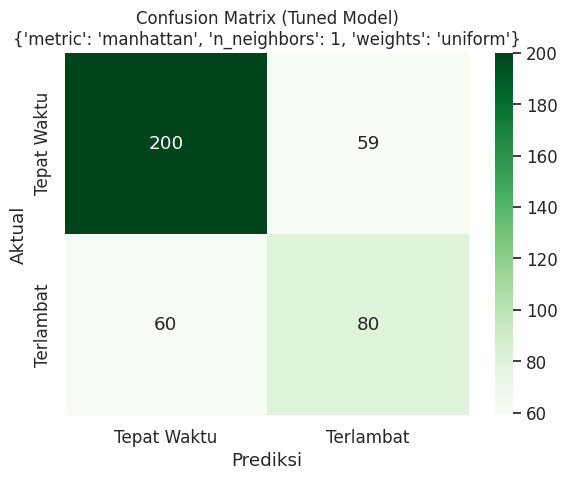

Model terbaik tersimpan di variabel 'best_knn'.


In [ ]:
# =========================================================
# ANALISIS D (REVISI): HYPERPARAMETER TUNING & EVALUASI
# =========================================================
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Tentukan Parameter
param_grid = {
    'n_neighbors': range(1, 30, 2), # Ganjil 1-29
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# 2. Inisialisasi & Fit Grid Search
knn_grid = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=knn_grid, param_grid=param_grid,
                           cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)

print("Sedang melakukan tuning... (Tunggu sebentar)")
grid_search.fit(X_train_resampled, y_train_resampled)

# 3. Simpan Model Terbaik ke Variabel Baru 'best_knn'
best_knn = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("\n=== HASIL HYPERPARAMETER TUNING ===")
print(f"Parameter Terbaik: {best_params}")
print(f"Best CV Score (F1-Macro): {best_score:.4f}")

# =========================================================
# EVALUASI MODEL TERBAIK (BEST_KNN) PADA DATA TEST
# =========================================================

# Prediksi menggunakan model hasil tuning
y_pred_tuned = best_knn.predict(X_test_scaled)
y_proba_tuned = best_knn.predict_proba(X_test_scaled)[:, 1]

# Classification Report
print("\n=== CLASSIFICATION REPORT (TUNED MODEL) ===")
target_names = [str(c) for c in le.classes_]
print(classification_report(y_test, y_pred_tuned, target_names=target_names))

# Confusion Matrix Visualization
cm_tuned = confusion_matrix(y_test, y_pred_tuned)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Greens', xticklabels=target_names, yticklabels=target_names)
plt.title(f'Confusion Matrix (Tuned Model)\n{best_params}', fontsize=12)
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.tight_layout()
plt.show()

print("Model terbaik tersimpan di variabel 'best_knn'.")


Menghitung Feature Importance... (Harap tunggu)

=== FEATURE IMPORTANCE RANKING ===
           Feature  Importance       Std
2    IP_LULUS_SMT3    0.062021  0.018501
5    IP_LULUS_SMT6    0.058380  0.021723
8   SKS_LULUS_SMT3    0.058284  0.015655
1    IP_LULUS_SMT2    0.055976  0.012411
0    IP_LULUS_SMT1    0.054872  0.016631
3    IP_LULUS_SMT4    0.054246  0.017319
10  SKS_LULUS_SMT5    0.050941  0.012545
4    IP_LULUS_SMT5    0.043257  0.011599
7   SKS_LULUS_SMT2    0.036895  0.010314
6   SKS_LULUS_SMT1    0.033028  0.010364
9   SKS_LULUS_SMT4    0.030475  0.011750
11  SKS_LULUS_SMT6    0.027690  0.009844


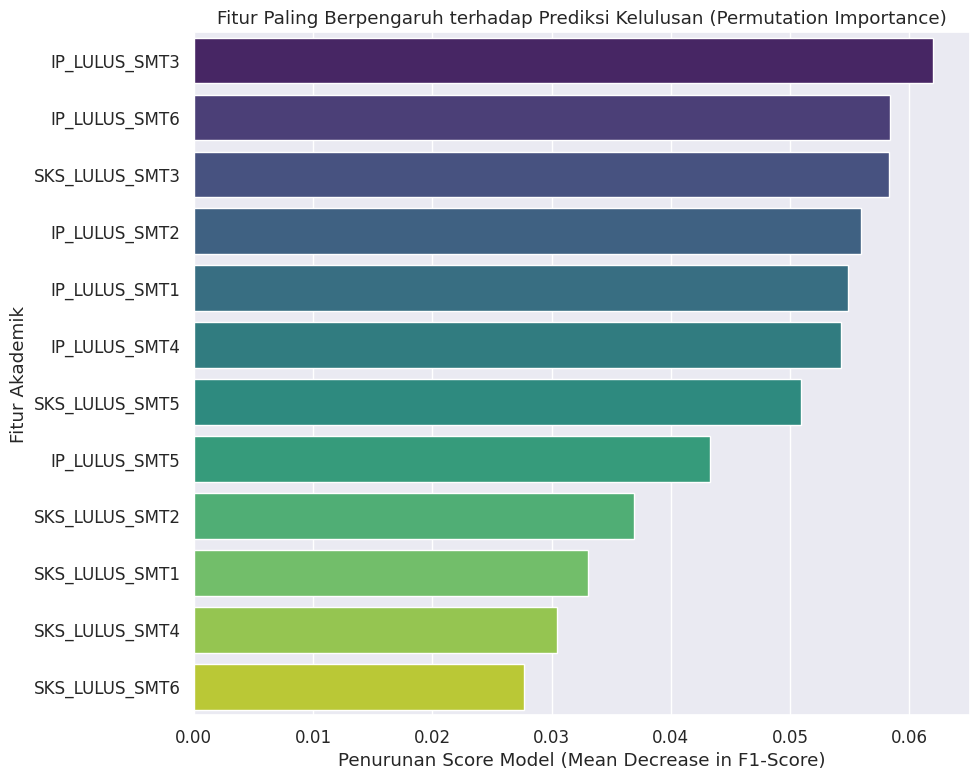

In [ ]:
# =========================================================
# ANALISIS E: FEATURE IMPORTANCE (Permutation Importance)
# =========================================================
from sklearn.inspection import permutation_importance

# Pastikan menggunakan model terbaik hasil tuning tadi
model_to_test = knn

# 1. Jalankan Permutation Importance pada Data TEST
# Kita tes pada data test agar tahu fitur mana yang penting untuk GENERALISASI
print("\nMenghitung Feature Importance... (Harap tunggu)")
result = permutation_importance(
    model_to_test, X_test_scaled, y_test,
    n_repeats=10, random_state=42, scoring='f1_macro'
)

# 2. Buat DataFrame Hasil
feature_names = X.columns # Nama kolom asli
importances = result.importances_mean
std = result.importances_std

df_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances,
    'Std': std
}).sort_values(by='Importance', ascending=False)

print("\n=== FEATURE IMPORTANCE RANKING ===")
print(df_importance)

# 3. Visualisasi Bar Chart
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=df_importance, palette='viridis')
plt.title('Fitur Paling Berpengaruh terhadap Prediksi Kelulusan (Permutation Importance)')
plt.xlabel('Penurunan Score Model (Mean Decrease in F1-Score)')
plt.ylabel('Fitur Akademik')
plt.tight_layout()
plt.show()

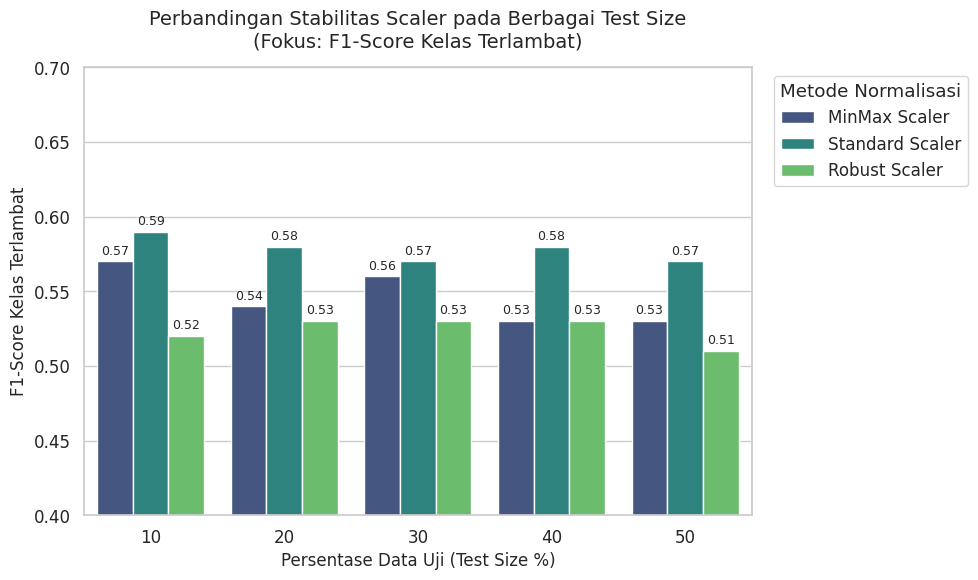

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# =========================================================
# DATA DARI CSV PENGUJIANMU (Filter 10% - 50%)
# Metrik: F1_Terlambat
# =========================================================

data = {
    'Test Size': [10, 20, 30, 40, 50] * 3,
    'Scaler':
        ['MinMax Scaler'] * 5 +
        ['Standard Scaler'] * 5 +
        ['Robust Scaler'] * 5,

    'F1-Score (Terlambat)': [
        # --- MinMax Scaler (10% - 50%) ---
        0.57, 0.54, 0.56, 0.53, 0.53,

        # --- Standard Scaler (10% - 50%) ---
        0.59, 0.58, 0.57, 0.58, 0.57,

        # --- Robust Scaler (10% - 50%) ---
        0.52, 0.53, 0.53, 0.53, 0.51
    ]
}

df_viz = pd.DataFrame(data)

# =========================================================
# PLOTTING
# =========================================================
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Grouped Bar Chart
ax = sns.barplot(
    data=df_viz,
    x='Test Size',
    y='F1-Score (Terlambat)',
    hue='Scaler',
    palette='viridis'
)

# Judul & Label
plt.title('Perbandingan Stabilitas Scaler pada Berbagai Test Size\n(Fokus: F1-Score Kelas Terlambat)', fontsize=14, pad=15)
plt.xlabel('Persentase Data Uji (Test Size %)', fontsize=12)
plt.ylabel('F1-Score Kelas Terlambat', fontsize=12)
plt.ylim(0.4, 0.7) # Zoom in range 0.4 - 0.7 agar bedanya terlihat
plt.legend(title='Metode Normalisasi', bbox_to_anchor=(1.02, 1), loc='upper left')

# Angka di atas batang
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3, fontsize=9)

plt.tight_layout()
plt.show()

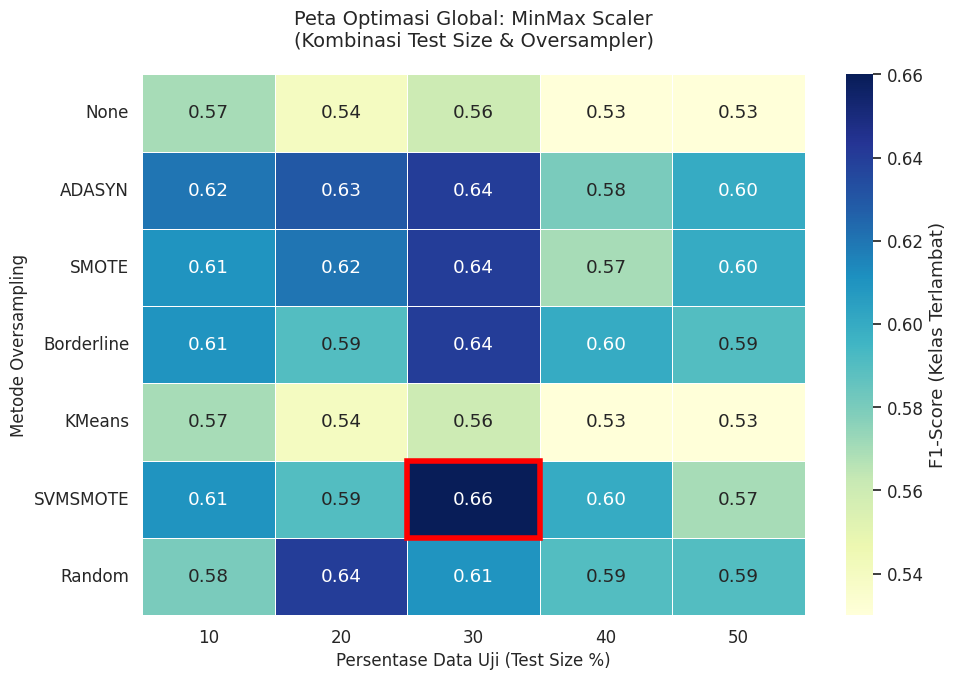

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.patches import Rectangle

# =========================================================
# DATA REAL DARI HASIL EKSPERIMENMU (Filter: MinMax Scaler)
# Metrik: F1-Score Kelas Terlambat
# =========================================================

# Baris: Oversampler, Kolom: Test Size (10, 20, 30, 40, 50)
f1_scores = np.array([
    [0.57, 0.54, 0.56, 0.53, 0.53], # None
    [0.62, 0.63, 0.64, 0.58, 0.60], # ADASYN
    [0.61, 0.62, 0.64, 0.57, 0.60], # SMOTE
    [0.61, 0.59, 0.64, 0.60, 0.59], # BorderlineSMOTE
    [0.57, 0.54, 0.56, 0.53, 0.53], # KMeansSMOTE
    [0.61, 0.59, 0.66, 0.60, 0.57], # SVMSMOTE <--- JUARA (0.66)
    [0.58, 0.64, 0.61, 0.59, 0.59]  # RandomOverSampler
])

oversamplers = ['None', 'ADASYN', 'SMOTE', 'Borderline', 'KMeans', 'SVMSMOTE', 'Random']
test_sizes = [10, 20, 30, 40, 50]

df_heatmap = pd.DataFrame(f1_scores, index=oversamplers, columns=test_sizes)

# =========================================================
# PLOTTING
# =========================================================
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.1)

# Heatmap
ax = sns.heatmap(
    df_heatmap,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    linewidths=.5,
    cbar_kws={'label': 'F1-Score (Kelas Terlambat)'}
)

# Highlight Kotak Pemenang (30% + SVMSMOTE)
# Koordinat (x=2, y=5) karena indeks mulai dari 0
ax.add_patch(Rectangle((2, 5), 1, 1, fill=False, edgecolor='red', lw=4, clip_on=False))

plt.title('Peta Optimasi Global: MinMax Scaler\n(Kombinasi Test Size & Oversampler)', fontsize=14, pad=20)
plt.xlabel('Persentase Data Uji (Test Size %)', fontsize=12)
plt.ylabel('Metode Oversampling', fontsize=12)

plt.tight_layout()
plt.show()

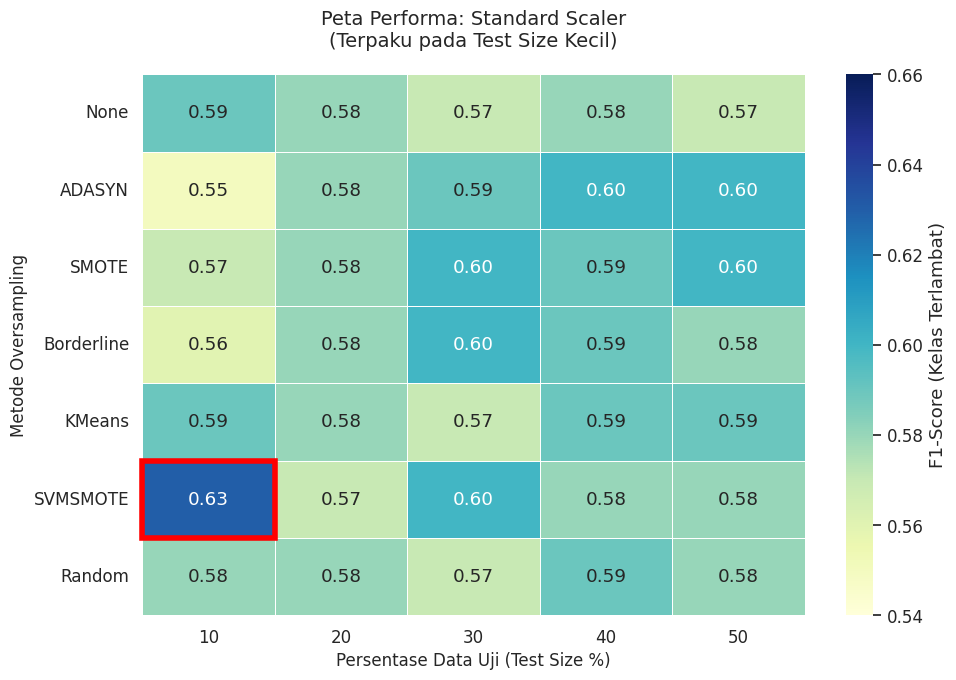

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.patches import Rectangle

# =========================================================
# DATA REAL: STANDARD SCALER (Diambil dari tabelmu)
# Metrik: F1-Score Kelas Terlambat
# =========================================================

# Baris: Oversampler
# Kolom: Test Size (10, 20, 30, 40, 50)

f1_standard = np.array([
    [0.59, 0.58, 0.57, 0.58, 0.57], # None
    [0.55, 0.58, 0.59, 0.60, 0.60], # ADASYN
    [0.57, 0.58, 0.60, 0.59, 0.60], # SMOTE
    [0.56, 0.58, 0.60, 0.59, 0.58], # BorderlineSMOTE
    [0.59, 0.58, 0.57, 0.59, 0.59], # KMeansSMOTE
    [0.63, 0.57, 0.60, 0.58, 0.58], # SVMSMOTE (Puncak di 10%)
    [0.58, 0.58, 0.57, 0.59, 0.58]  # RandomOverSampler
])

oversamplers = ['None', 'ADASYN', 'SMOTE', 'Borderline', 'KMeans', 'SVMSMOTE', 'Random']
test_sizes = [10, 20, 30, 40, 50]

df_heatmap_std = pd.DataFrame(f1_standard, index=oversamplers, columns=test_sizes)

# =========================================================
# PLOTTING
# =========================================================
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.1)

# Heatmap dengan batas warna yang sama dengan MinMax (0.54 - 0.66)
# Agar "redup"-nya kelihatan dibanding MinMax nanti
ax = sns.heatmap(
    df_heatmap_std,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    linewidths=.5,
    vmin=0.54, vmax=0.66, # PENTING: Samakan scale ini dengan Heatmap MinMax nanti
    cbar_kws={'label': 'F1-Score (Kelas Terlambat)'}
)

# Highlight Pemenang Sekuensial (10% + SVMSMOTE)
# Koordinat (x=0, y=5)
ax.add_patch(Rectangle((0, 5), 1, 1, fill=False, edgecolor='red', lw=4, clip_on=False))

plt.title('Peta Performa: Standard Scaler\n(Terpaku pada Test Size Kecil)', fontsize=14, pad=20)
plt.xlabel('Persentase Data Uji (Test Size %)', fontsize=12)
plt.ylabel('Metode Oversampling', fontsize=12)

plt.tight_layout()
# plt.savefig('heatmap_standard_scaler.png', dpi=300)
plt.show()

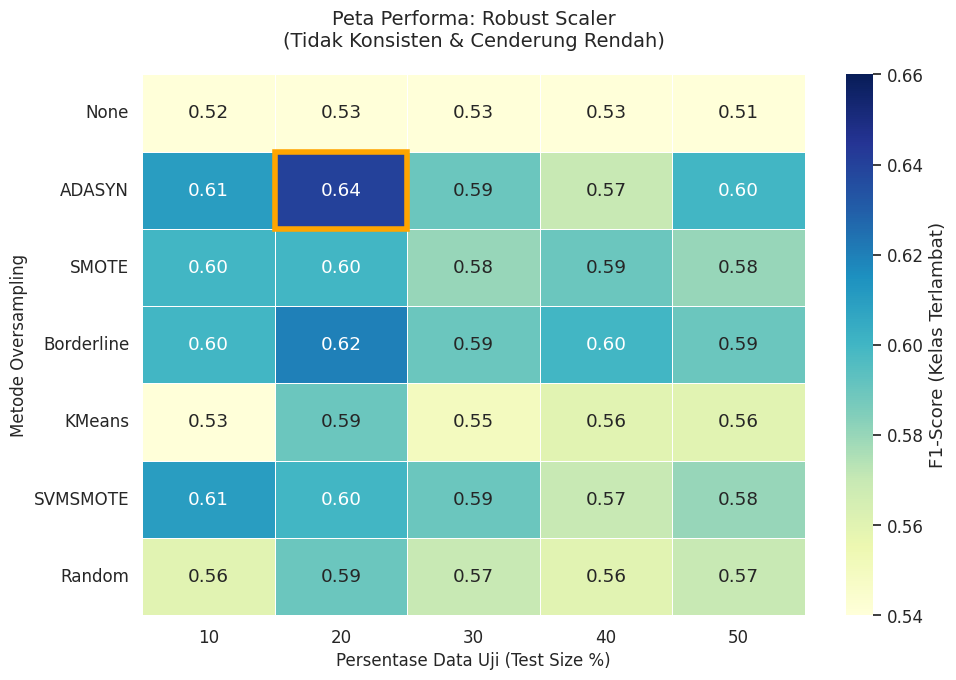

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.patches import Rectangle

# =========================================================
# DATA REAL: ROBUST SCALER (Diambil dari tabelmu)
# Metrik: F1-Score Kelas Terlambat
# =========================================================

# Baris: Oversampler (None, ADASYN, SMOTE, Borderline, KMeans, SVMSMOTE, Random)
# Kolom: Test Size (10, 20, 30, 40, 50)

f1_robust = np.array([
    [0.52, 0.53, 0.53, 0.53, 0.51], # None
    [0.61, 0.64, 0.59, 0.57, 0.60], # ADASYN (Puncak di 20%)
    [0.60, 0.60, 0.58, 0.59, 0.58], # SMOTE
    [0.60, 0.62, 0.59, 0.60, 0.59], # BorderlineSMOTE
    [0.53, 0.59, 0.55, 0.56, 0.56], # KMeansSMOTE
    [0.61, 0.60, 0.59, 0.57, 0.58], # SVMSMOTE
    [0.56, 0.59, 0.57, 0.56, 0.57]  # RandomOverSampler
])

oversamplers = ['None', 'ADASYN', 'SMOTE', 'Borderline', 'KMeans', 'SVMSMOTE', 'Random']
test_sizes = [10, 20, 30, 40, 50]

df_heatmap_rob = pd.DataFrame(f1_robust, index=oversamplers, columns=test_sizes)

# =========================================================
# PLOTTING
# =========================================================
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.1)

# Menggunakan range warna yang SAMA dengan MinMax (0.54 - 0.66)
# Agar terlihat jelas kalau Robust Scaler lebih "pucat" (performanya lebih rendah)
ax = sns.heatmap(
    df_heatmap_rob,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    linewidths=.5,
    vmin=0.54, vmax=0.66,
    cbar_kws={'label': 'F1-Score (Kelas Terlambat)'}
)

# Highlight Pemenang di Robust Scaler (20% + ADASYN)
# Koordinat (x=1, y=1)
ax.add_patch(Rectangle((1, 1), 1, 1, fill=False, edgecolor='orange', lw=4, clip_on=False))

plt.title('Peta Performa: Robust Scaler\n(Tidak Konsisten & Cenderung Rendah)', fontsize=14, pad=20)
plt.xlabel('Persentase Data Uji (Test Size %)', fontsize=12)
plt.ylabel('Metode Oversampling', fontsize=12)

plt.tight_layout()
plt.show()